In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import imblearn
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

In [160]:
data = pd.read_parquet("../data/df_cleaned.parquet")
data

,transaction_date,amount,memo,new_category,Cleaned Text
8,2018-03-06,15.25,POS CASINO BAR @ SPOTL - MEMO=PURCHASE 03/02 C...,Entertainment,pos casino bar spotl memopurchase 0302 coache...
39,2018-09-29,16.04,BEST BUY GRAND REGENCY BRANDON F,General Merchandise,best buy grand regency brandon f
45,2018-10-17,10.36,CORNER STORE ARLINGTON TX 10/17 Purchase $5.3...,Automotive,corner store arlington tx 1017 purchase $536 ...
52,2017-07-11,4.63,SPEEDWAY IN BEDFORD IN 07/10 DEBIT_CARD,Automotive,speedway bedford 0710 debitcard
55,2018-09-10,223.00,PAYMENT FOR AMZ STORECARD WEB ID: ACH_DEBIT,General Merchandise,payment amz storecard web id achdebit
...,...,...,...,...,...
1999981,2021-02-19,24.24,DBT/WDR CASEYS GEN STORE FENNIMORE WI,Automotive,dbtwdr caseys gen store fennimore wi
1999982,2021-01-19,120.60,POS Debit - DDA KOHLS CLIVE IA #,General Merchandise,pos debit dda kohls clive ia
1999983,2022-02-25,6.47,STARBUCKS STORE MAPLE VALLEY WA 02/24,Food and Beverages,starbucks store maple valley wa 0224
1999991,2021-01-11,44.98,POS Debit - Visa Check Card - APPLE.COM/BILL ...,General Merchandise,pos debit visa check card applecombill ca


In [161]:
data['new_category'].value_counts(normalize=True)

Food and Beverages     0.326565
General Merchandise    0.280126
Automotive             0.128234
Groceries              0.128081
Entertainment          0.063479
Travel                 0.051383
Healthcare/Medical     0.016916
Pets/Pet Care          0.005217
Name: new_category, dtype: float64

# Part 1: TF-IDF Model

##### Koosha's TF-IDF model + Nathan's fine-tuning

In [162]:
# define the feature columns
feature_columns = "Cleaned Text"

# define the target column
target_column = "new_category"

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the target column
y = le.fit_transform(data[target_column])

# create the feature matrix and target vector
X = data[feature_columns]

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
X_test.to_csv('../test/text_test_data.csv', index_label=False)

In [163]:
# le.classes_
for i in range(8):
    print(i, le.inverse_transform([i]))

0 ['Automotive']
1 ['Entertainment']
2 ['Food and Beverages']
3 ['General Merchandise']
4 ['Groceries']
5 ['Healthcare/Medical']
6 ['Pets/Pet Care']
7 ['Travel']


In [149]:
# create the TfidfVectorizer
vectorizer = TfidfVectorizer()

# create the pipeline
pipeline = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LogisticRegression())
])

# fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [150]:
# test the model on the test data
test_data = "autozone"
predicted_category = pipeline.predict([test_data])

print("Predicted category:", le.inverse_transform(predicted_category))

Predicted category: ['Automotive']


In [151]:
# evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Test score:", score)

Test score: 0.8549399824633898


### Parameter Tuning

In [9]:
def trainTestTFIDF(gram='word', ngram_range=(1,1)):
        # create the TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer=gram, ngram_range=ngram_range)

    # create the pipeline
    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("classifier", LogisticRegression())
    ])

    # fit the model on the training data
    pipeline.fit(X_train, y_train)
    
    # evaluate the model on the test data
    score = pipeline.score(X_test, y_test)
    print("Test score:", score)
    return pipeline

In [10]:
# trainTestTFIDF('word')
# trainTestTFIDF('word', ngram_range=(2,2)) # bigrams
# trainTestTFIDF('word', ngram_range=(3,3)) # trigrams
# trainTestTFIDF('char')
# trainTestTFIDF('char', ngram_range=(2,2))
# trainTestTFIDF('char', ngram_range=(3,3))
# trainTestTFIDF('char', ngram_range=(4,4))

best_tfidf = trainTestTFIDF('char', ngram_range=(5,5)) # BEST
#  '123 4567' includes: '123 4', '23 45', '3 456', ' 4567'

# trainTestTFIDF('char', ngram_range=(6,6))
# trainTestTFIDF('char', ngram_range=(7,7))
# trainTestTFIDF('char', ngram_range=(8,8))

tfidf_proba = best_tfidf.predict_proba(X_test)

Test score: 0.8791888813859969


In [155]:
import pickle as pkl


pkl.dump(model,open("../test/models/text_model.pkl", "wb"))

In [153]:
best_tfidf

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(5, 5))),
                ('classifier', LogisticRegression())])

# Part 2: Non-Text Model
##### Kyle's Non-Text Model

In [172]:
data['dt'] = pd.to_datetime(data['transaction_date'])
data = data[["amount", "dt", "new_category"]]
data

KeyError: 'transaction_date'

In [173]:
# feature engineering using dt column: adding year, month, day, etc.
data['year'] = data['dt'].dt.year # ranges 2010 - 2022
data['month'] = data['dt'].dt.month # ranges 1 - 12
data['is_holiday'] = data['month'].apply(lambda x: 1 if x == 11 or x == 12 else 0) # 0 or 1
data['day'] = data['dt'].dt.dayofweek # to be discarded
data['is_weekend'] = data['day'].apply(lambda x: 1 if x == 5 or x == 6 else 0) # 0 or 1

# feature engineering using amount: encoding whole numbers
data['is_whole_number'] = data['amount'].apply(lambda x: 1 if str(x).split(".")[1] == "0" else 0)
data

# X y split
X = data[["amount", "is_whole_number", "year", "month", "day", "is_holiday", "is_weekend"]]
y = data[["new_category"]]

#amount bins
bins = [0, 10, 50, 100, float('inf')]

amount_bin_labels = ['10', '10-50', '50-100', '100']

# Create a new column in the DataFrame that categorizes transaction amounts
binned_amount = pd.DataFrame()
binned_amount['Amount Range'] = pd.cut(X['amount'], bins=bins, labels=amount_bin_labels)


# One-hot encode the "Amount Range" column
one_hot = pd.get_dummies(binned_amount['Amount Range'], prefix='Amount')

binned_amount = pd.concat([binned_amount, one_hot], axis=1)

# Drop the original "Amount Range" column
binned_amount.drop('Amount Range', axis=1, inplace=True)


# standard scale: amount
scaler = StandardScaler()
scaler_df = pd.DataFrame(scaler.fit_transform(X[['amount']]), index = X.index)



# one hot encode: year, month, day
ohe = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(ohe.fit_transform(X[['year']]).toarray(), columns = pd.Series(X['year'].unique()).sort_values().values, index = X.index)

ohe2 = OneHotEncoder(handle_unknown='ignore')
encoder_df2 = pd.DataFrame(ohe2.fit_transform(X[['month']]).toarray(), columns = pd.Series(X['month'].unique()).sort_values().values, index = X.index)

# monday = 0, sunday = 6
def convert_date_to_day(date):
    if date == 0:
        return "monday"
    if date == 1:
        return "tuesday"
    if date == 2:
        return "wednesday"
    if date == 3:
        return "thursday"
    if date == 4:
        return "friday"
    if date == 5:
        return "saturday"
    if date == 6:
        return "sunday"

X['day_word'] = X['day'].apply(convert_date_to_day)
ohe3 = OneHotEncoder(handle_unknown='ignore')
encoder_df3 = pd.DataFrame(ohe3.fit_transform(X[['day_word']]).toarray(), columns = pd.Series(X['day_word'].unique()).sort_values().values, index = X.index)

# combine features and remove duplicate features
X = pd.concat([X, binned_amount, scaler_df, encoder_df, encoder_df2, encoder_df3], axis=1)
X = X[[0, 'is_whole_number', 'is_holiday', 'is_weekend','Amount_10', 'Amount_10-50', 'Amount_50-100', 'Amount_100', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]]
X.rename({0: "amount (standardized)"}, axis=1, inplace=True)

In [174]:
X

,amount (standardized),is_whole_number,is_holiday,is_weekend,Amount_10,Amount_10-50,Amount_50-100,Amount_100,1,2,...,10,11,12,monday,tuesday,wednesday,thursday,friday,saturday,sunday
8,-0.012686,0,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39,-0.012246,0,0,1,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45,-0.015409,0,0,0,0,1,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52,-0.018601,0,0,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.103030,1,0,0,0,0,0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999981,-0.007678,0,0,0,0,1,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1999982,0.045994,0,0,0,0,0,0,1,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1999983,-0.017576,0,0,0,1,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1999991,0.003874,0,0,0,0,1,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.to_csv('../test/non_text_test_data.csv', index_label=False)
X_train


,amount (standardized),is_whole_number,is_holiday,is_weekend,Amount_10,Amount_10-50,Amount_50-100,Amount_100,1,2,...,10,11,12,monday,tuesday,wednesday,thursday,friday,saturday,sunday
840091,0.002097,0,1,0,0,1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
851897,0.034520,1,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
80687,-0.011833,0,0,1,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1864630,-0.019381,0,0,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1640557,-0.020071,0,0,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193087,0.021152,1,0,1,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1004042,-0.005138,0,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1128639,0.027752,0,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1256522,-0.014936,0,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
# Instantiate the SMOTE object
smotenc = SMOTENC(categorical_features=np.arange(1,23,1),random_state=42)

# Resample the dataset using SMOTE
X_train, y_train = smotenc.fit_resample(X_train, y_train)

# Check the new class distribution
print(y_train.value_counts())

KeyboardInterrupt: 

In [16]:
# train model
lr = LogisticRegression(multi_class = "multinomial").fit(X_train, y_train)
y_train = le.transform(y_train)
rr = Ridge(alpha = 1).fit(X_train, y_train)
# sgd = SGDClassifier(loss="log").fit(X_train, y_train)

# predict and store predictions
lr_preds = le.transform(lr.predict(X_test))
# sgd_preds = sgd.predict(X_test)

y_test = np.array(y_test['new_category'])
y_test_encoded = le.transform(y_test)
y_test_encoded

array([0, 7, 2, ..., 2, 2, 4])

In [17]:
rr_preds = rr.predict(X_test)
pd.Series(rr_preds).sort_values()

40496   -5.075208
81923    2.764634
10528    2.764634
33470    2.764634
8960     2.764655
           ...   
2934     4.317508
58396    4.317512
81942    4.317531
19826    4.339289
59420    4.339289
Length: 99221, dtype: float64

In [18]:
lr_accuracy = (lr_preds == y_test_encoded).mean()
# sgd_accuracy = (sgd_preds == y_test_encoded).mean()
print("Logistic Regression accuracy: {}".format(lr_accuracy))


Logistic Regression accuracy: 0.15058304189637275


In [19]:
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# # Define the model
# model = xgb.XGBClassifier(n_jobs=-1)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [2, 3, 4]
# }

# # Define the grid search object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# # Fit the grid search object to the data
# grid_search.fit(X_train, y_train)

# # Make predictions on the test set using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Calculate the accuracy score
# accuracy = accuracy_score(y_test_encoded, y_pred)
# print("Accuracy:", accuracy)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)


In [20]:
model = xgb.XGBClassifier(n_jobs=-1, learning_rate=0.5, max_depth=4, n_estimators=150)
model.fit(X_train, y_train)

[16:48:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.21351326836052853


In [22]:
xgb_proba = model.predict_proba(X_test)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, normaltize='pred').round(2)

TypeError: confusion_matrix() got an unexpected keyword argument 'normaltize'

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

In [40]:
le.classes_

array(['Automotive', 'Entertainment', 'Food and Beverages',
       'General Merchandise', 'Groceries', 'Healthcare/Medical',
       'Pets/Pet Care', 'Travel'], dtype=object)

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)
plt.show()

ValueError: Mix of label input types (string and number)

In [157]:
import pickle as pkl


pkl.dump(model,open("../test/models/non_text_model.pkl", "wb"))

# Part 3: Composite Model
##### Kyle using Logistic Regression to combine the probabilities from each class from both models

In [42]:
tfidf_proba, xgb_proba, rr_preds

(array([[9.70859801e-01, 7.26371753e-03, 8.86511691e-03, ...,
         6.47559116e-04, 1.97423402e-04, 5.39751801e-03],
        [2.91438686e-03, 3.60615337e-03, 2.54363876e-02, ...,
         2.35694615e-03, 3.39156473e-04, 9.47733944e-01],
        [8.91183805e-04, 8.90854037e-04, 9.93612976e-01, ...,
         6.15146064e-04, 7.66017144e-05, 6.75411507e-04],
        ...,
        [8.65750856e-03, 2.86215958e-03, 9.66789448e-01, ...,
         3.02907759e-03, 3.10511866e-04, 3.87857135e-03],
        [6.18020642e-02, 2.75772151e-02, 2.12105473e-01, ...,
         1.91671625e-02, 2.33857307e-03, 3.41531753e-02],
        [8.30756134e-04, 3.64863095e-04, 2.66943638e-04, ...,
         1.90945053e-04, 9.98322442e-05, 5.60641245e-04]]),
 array([[0.04513837, 0.06030572, 0.05903848, ..., 0.15686518, 0.31062448,
         0.05109759],
        [0.28587508, 0.06211938, 0.082544  , ..., 0.07317608, 0.16630128,
         0.06217813],
        [0.13473438, 0.20254947, 0.1757814 , ..., 0.08148428, 0.10692174,

In [127]:
final_proba_tfidf = tfidf_proba * 1 + xgb_proba * 0

In [128]:
final_proba_ensemble = tfidf_proba * 0.9 + xgb_proba * 0.1

In [129]:
final_proba.shape

(99221, 8)

In [130]:
y_pred_tfidf = np.argmax(final_proba_tfidf,axis=1)
y_pred_ensemble = np.argmax(final_proba_ensemble,axis=1)

In [131]:
accuracy_tfidf = accuracy_score(y_test_encoded, y_pred_tfidf)
print("Accuracy:", accuracy_tfidf)

Accuracy: 0.8791888813859969


In [133]:
accuracy_ensemble = accuracy_score(y_test_encoded, y_pred_ensemble)
print("Accuracy:", accuracy_ensemble)

Accuracy: 0.8795617863153969


In [47]:
confusion_matrix(y_test_encoded, y_pred, normalize='pred').round(2)

array([[0.91, 0.  , 0.02, 0.02, 0.01, 0.  , 0.  , 0.03],
       [0.  , 0.93, 0.01, 0.03, 0.  , 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.89, 0.03, 0.03, 0.01, 0.  , 0.03],
       [0.03, 0.06, 0.04, 0.85, 0.1 , 0.15, 0.01, 0.01],
       [0.01, 0.  , 0.02, 0.05, 0.85, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.01, 0.  , 0.8 , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.92]])

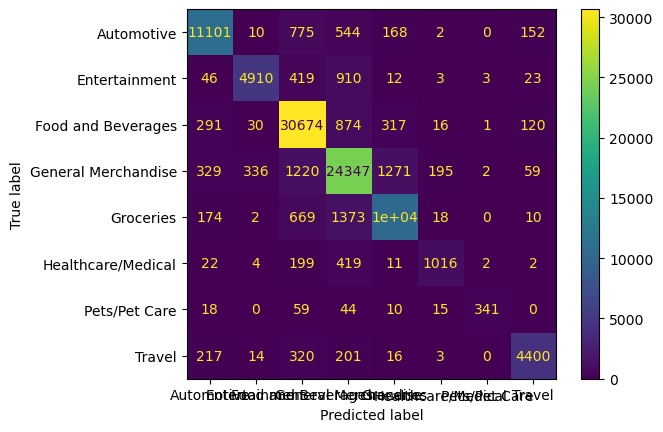

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
plt.show()

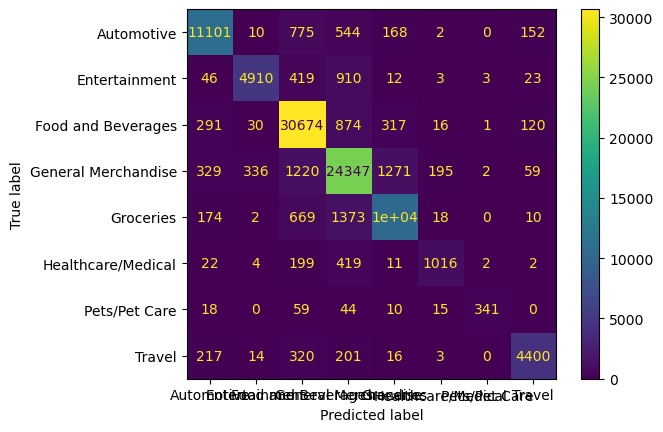

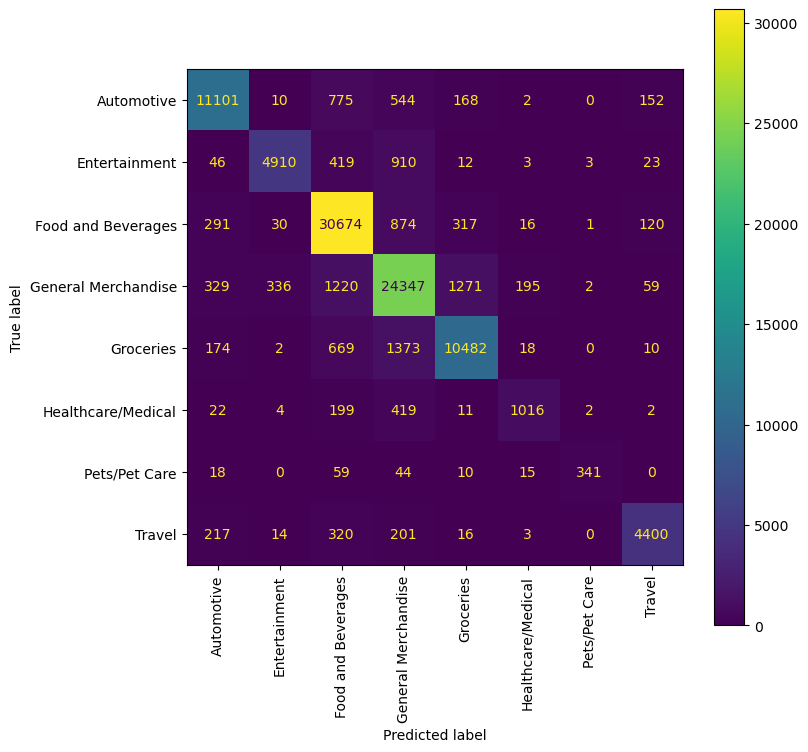

In [49]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # adjust the figure size
font_size = 10  # adjust the font size
disp.plot(include_values=True, ax=ax, xticks_rotation='vertical', values_format='.0f')
ax.set_xticklabels(disp.display_labels, fontsize=font_size, ha='center')  # adjust the font size and alignment
plt.show()

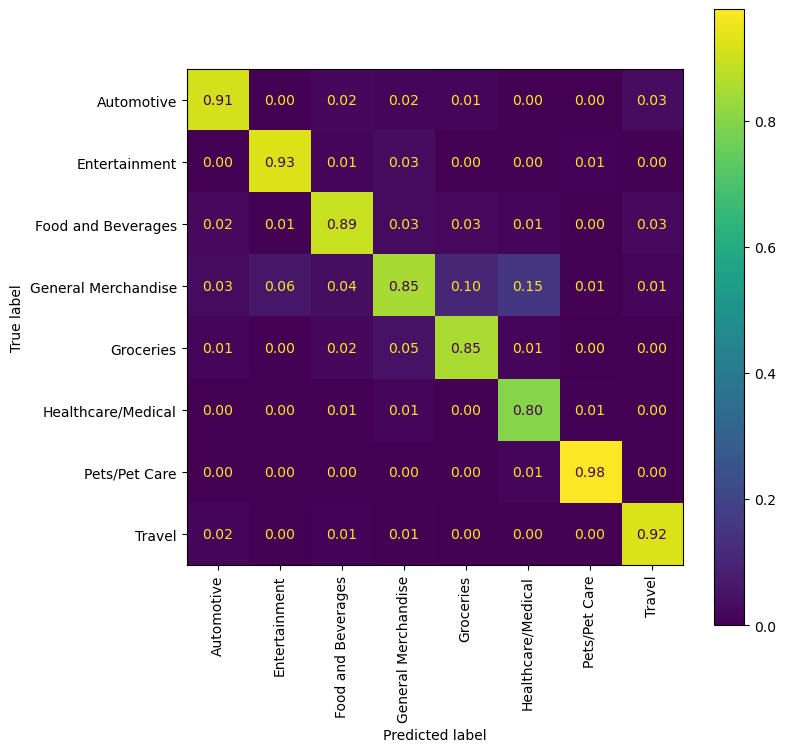

In [50]:
cm = confusion_matrix(y_test_encoded, y_pred, normalize='pred')#.round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # adjust the figure size
font_size = 10  # adjust the font size
disp.plot(include_values=True, ax=ax, xticks_rotation='vertical', values_format='.2f')
ax.set_xticklabels(disp.display_labels, fontsize=font_size, ha='center')  # adjust the font size and alignment
plt.show()

In [51]:
cm.round(2)

array([[0.91, 0.  , 0.02, 0.02, 0.01, 0.  , 0.  , 0.03],
       [0.  , 0.93, 0.01, 0.03, 0.  , 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.89, 0.03, 0.03, 0.01, 0.  , 0.03],
       [0.03, 0.06, 0.04, 0.85, 0.1 , 0.15, 0.01, 0.01],
       [0.01, 0.  , 0.02, 0.05, 0.85, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.01, 0.  , 0.8 , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.92]])

In [52]:
cm = confusion_matrix(y_test_encoded, y_pred, normalize='pred').round(2)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.show()

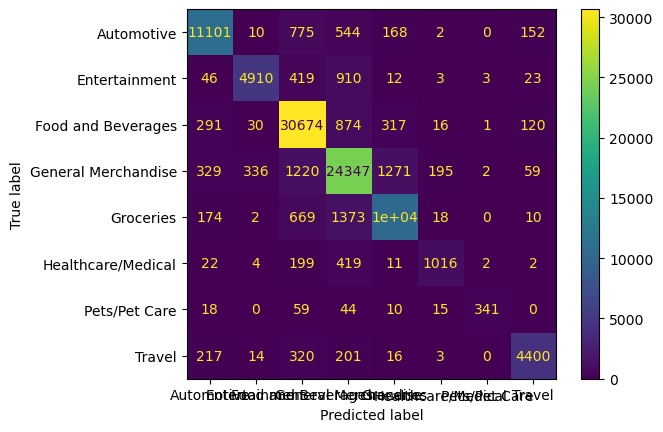

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
plt.show()

In [54]:
# lr_proba = lr.predict_proba(X_test)
# # final_model = LogisticRegression().fit()
# for weight in range(0,20): # learn weight
#     weighted_average = nontext_proba + weight*tfidf_proba
#     final_df = pd.DataFrame(weighted_average)
# # todo: do a sanity check on this model. look at a specific transaction and trace it
#     final_model = LogisticRegression().fit(final_df, y_test)
    
#     preds = final_model.predict(final_df)
#     print(weight, np.mean(preds == y_test))

In [55]:
# COMPOSITE MODEL DOES NOT WORK
# next week:
# -kyle: think about trying ridge regression
# -try to combine the X_train non-text and text data rather than combining the predictions
# -both text and non-text were already trained on LR so shouldn't be too difficult
# -might have to take it out of the pipeline
# -start working on bert and gpt

In [38]:
X = vectorizer.fit_transform(corpus)

NameError: name 'corpus' is not defined

Export data for project reproduction

In [ ]:
import pickle as pkl

pkl.dump(model,open("model.pkl", "wb"))

In [ ]:
test.to_csv('../../test/testdata.csv', index_label=False)

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [177]:
X_test

,amount (standardized),is_whole_number,is_holiday,is_weekend,Amount_10,Amount_10-50,Amount_50-100,Amount_100,1,2,...,10,11,12,monday,tuesday,wednesday,thursday,friday,saturday,sunday
77264,0.021413,0,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
945146,0.001156,0,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1572760,-0.018144,0,0,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1280479,-0.018228,0,0,0,1,0,0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1743255,-0.015142,0,1,0,0,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868396,-0.006141,1,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1726984,-0.012396,0,0,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1159091,-0.019381,0,0,0,1,0,0,0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1933459,0.027641,0,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
